In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=str(3)

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from models import seq2point_gaussian

In [4]:
train ={ 
    1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    }
}
test = {
     2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
}
appliances = ["Dish Washer"]

In [5]:
datas = dataset_load(appliances, train, test, 19,split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test,y_test = datas[4],datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [6]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[:,0]
calibration_predictions_df['Ground Truth']=scaler_y.inverse_transform(y_cal)[:,0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test


## Seq2point

In [7]:
model = seq2point_gaussian.seq2point()


In [8]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

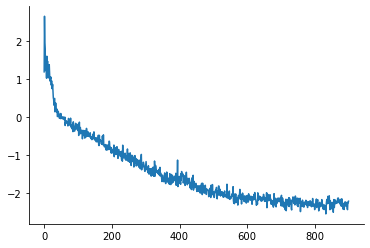

In [9]:
plt.plot(losses)
sns.despine()

In [10]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 10.9 s'

#### Training Results

In [11]:
y_hat = model.apply(params, x_train, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [12]:
train_mean = scaler_y.inverse_transform(y_hat[0])
train_sigma = scaler_y.scale_*y_hat[1]
y_true = scaler_y.inverse_transform(y_train)

In [13]:
print(f"RMSE : {errors.rmse(y_true, train_mean):.4f} MAE  : {errors.mae(y_true, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_true):.4f}")

RMSE : 93.9288 MAE  : 18.1304 NLL : 3.9055


In [14]:
training_predictions_df['mean']=train_mean
training_predictions_df['sigma']=train_sigma
training_predictions_df.head()

,Ground Truth,mean,sigma
0,1.000000e+00,2.308422,0.753802
1,1.000000e+00,2.209702,0.747795
2,1.000000e+00,2.352015,0.666094
3,8.209751e-08,2.200901,0.704724
4,6.875001e-01,2.125240,1.143002


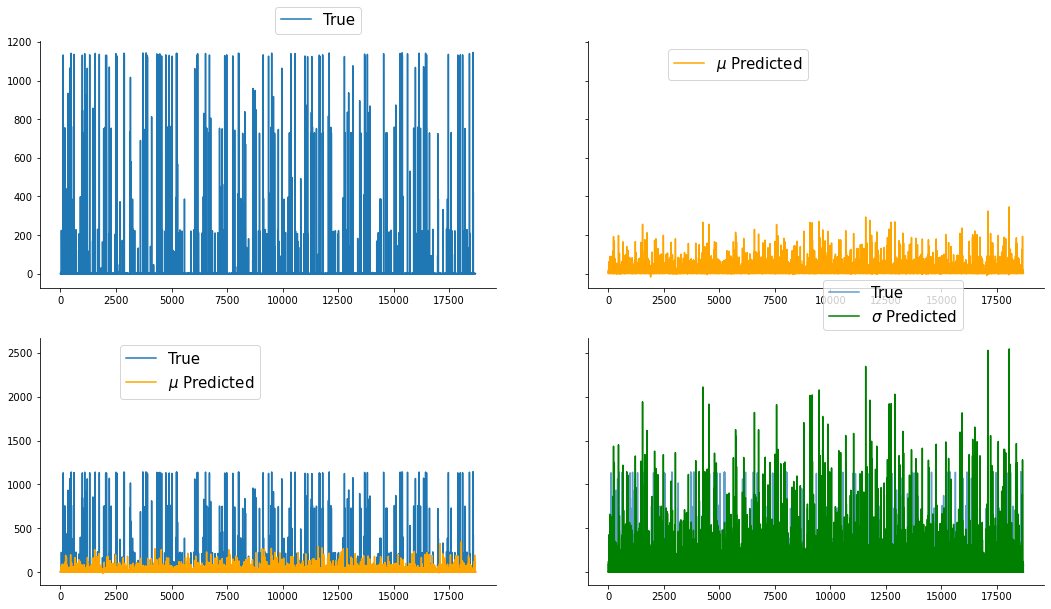

In [15]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10),sharey='row')
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Calibration Set Results

In [16]:
y_hat_cal = model.apply(params, x_cal, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [17]:
cal_mean = scaler_y.inverse_transform(y_hat_cal[0])
cal_sigma = scaler_y.scale_*y_hat_cal[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [18]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 86.0145 MAE  : 16.5766 NLL : 3.9329


In [19]:
calibration_predictions_df['mean']=cal_mean
calibration_predictions_df['sigma']=cal_sigma

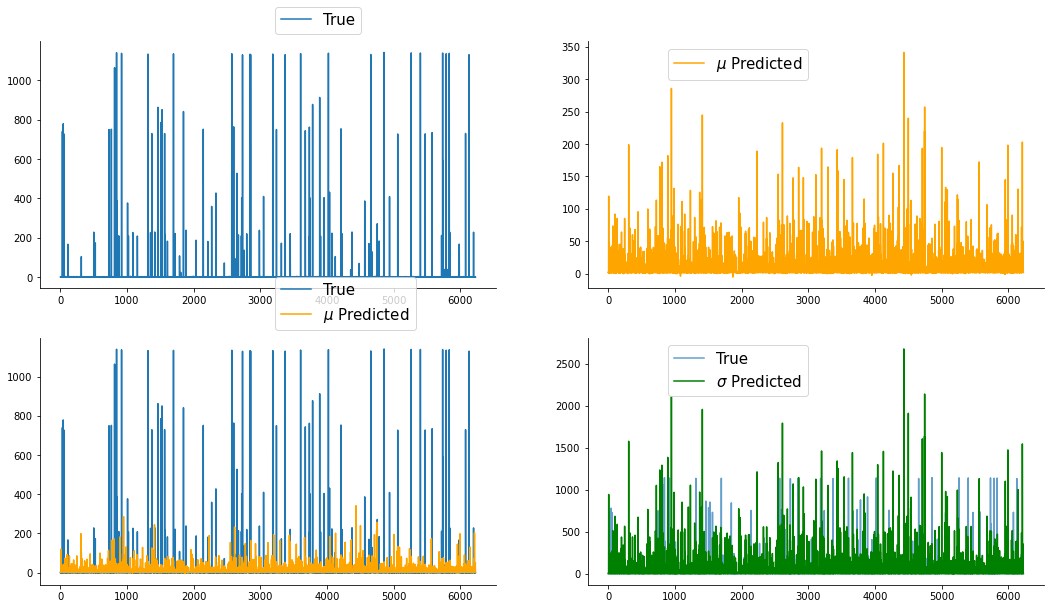

In [20]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Testing Results

In [21]:
%%capture cap
%%time
y_hat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})


In [22]:
test_mean = scaler_y.inverse_transform(y_hat[0])
test_sigma = scaler_y.scale_*y_hat[1]

In [23]:
mlp_testing_time = cap.stdout.split('\n')[1]

In [24]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test,test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 93.1351 MAE  : 12.4671 NLL : 7.3388


In [25]:
testing_predictions_df["mean"] = test_mean
testing_predictions_df["sigma"] = test_sigma

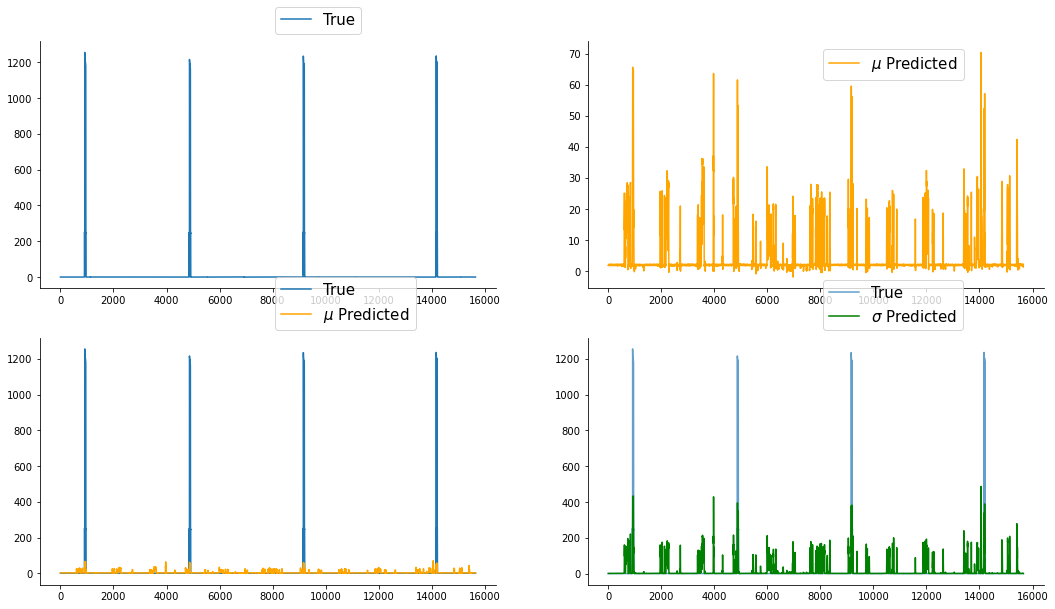

In [26]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Calibration

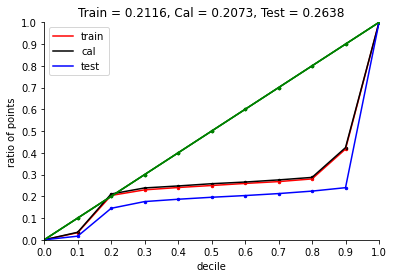

In [27]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(train_mean.squeeze(), train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(cal_mean.squeeze(), cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(test_mean.squeeze(), test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## MC Dropout

In [28]:
n_stacks = 10
fn = lambda x, i : model.apply(params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})

#### Training Results

In [29]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_train, jnp.arange(n_stacks))

In [30]:
mc_train_mean,mc_train_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [31]:
mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)

In [32]:
print(f"RMSE : {errors.rmse(y_true, mc_train_mean):.4f}", f"MAE  : {errors.mae(y_true, mc_train_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_train_mean, mc_train_sigma, y_true):.4f}")

RMSE : 93.7232 MAE  : 16.3188 NLL  : 2.1510


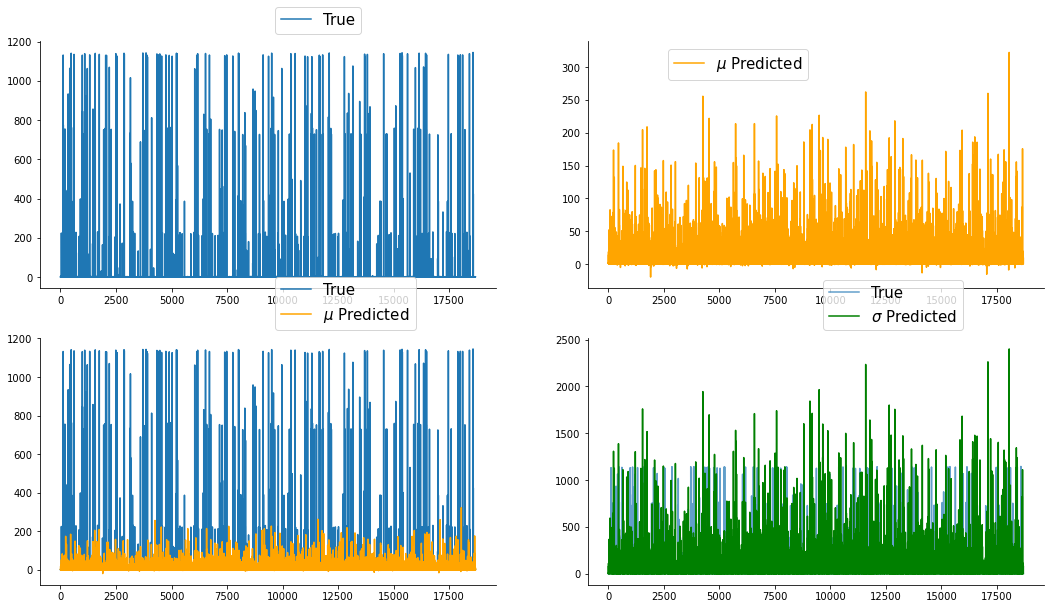

In [33]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [34]:
training_predictions_df['MC_mean']=mc_train_mean
training_predictions_df['MC_sigma']=mc_train_sigma

#### Calibration Set Results

In [35]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_cal, jnp.arange(n_stacks))

In [36]:
mc_cal_mean,mc_cal_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [37]:
mc_cal_mean = scaler_y.inverse_transform(mc_cal_mean)
mc_cal_sigma = (scaler_y.scale_*mc_cal_sigma)

In [38]:
print(f"RMSE : {errors.rmse(y_true_cal, mc_cal_mean):.4f}", f"MAE  : {errors.mae(y_true_cal, mc_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_cal_mean, mc_cal_sigma, y_true_cal):.4f}")

RMSE : 85.7047 MAE  : 14.7259 NLL  : 2.2012


In [39]:
calibration_predictions_df['MC_Mean'] =mc_cal_mean
calibration_predictions_df['MC_Sigma'] =mc_cal_sigma

#### Testing Results

In [40]:
%%capture cap
%%time
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_test, jnp.arange(n_stacks))

In [41]:
mc_testing_time = cap.stdout.split('\n')[1]
mc_testing_time

'Wall time: 776 ms'

In [42]:
mc_test_mean,mc_test_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [43]:
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)

In [44]:
print(f"RMSE : {errors.rmse(y_test, mc_test_mean):.4f}", f"MAE  : {errors.mae(y_test, mc_test_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_test_mean, mc_test_sigma, y_test):.4f}")

RMSE : 93.5558 MAE  : 11.1564 NLL  : 5.2781


In [45]:
testing_predictions_df['MC_Mean'] =  mc_test_mean
testing_predictions_df['MC_Sigma'] = mc_test_sigma

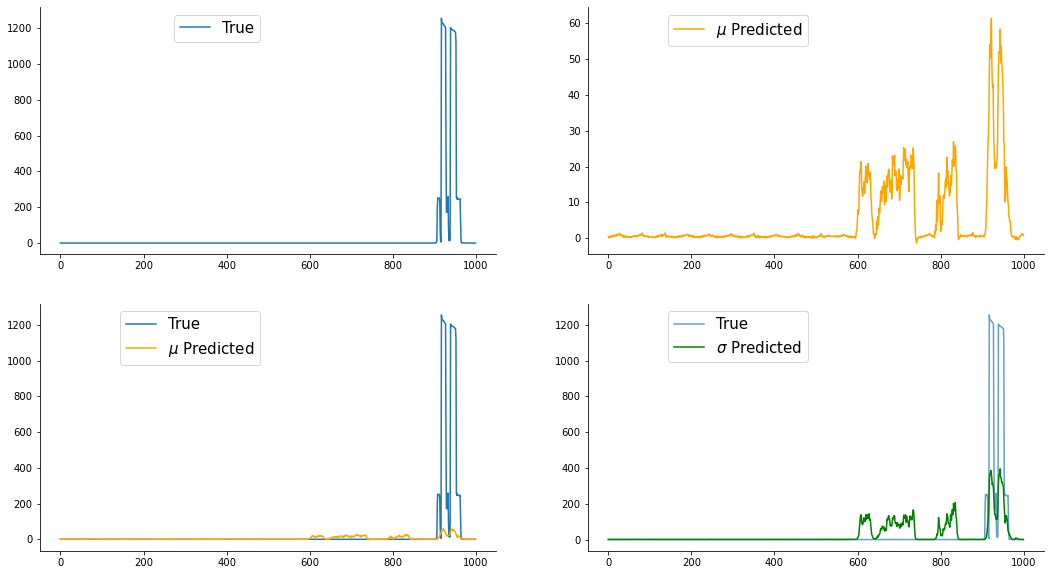

In [46]:
idx1 = 0
idx2 = 1000
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

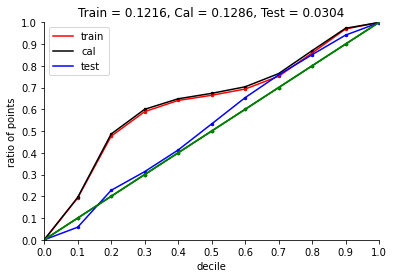

In [47]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(mc_train_mean.squeeze(), mc_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(mc_cal_mean.squeeze(), mc_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(mc_test_mean.squeeze(), mc_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Deep Ensemble

In [48]:
def de_train(x, y, i, model):
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=1024, 
                      learning_rate=0.0001, epochs=50)
    return param, losses
    
de_train = jax.tree_util.Partial(de_train, model=model)

def predict(x, param, model):
    yhat = model.apply(param,x,True)
    return yhat
test_ = jax.tree_util.Partial(predict, model=model)

In [49]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

2022-07-23 13:58:18.103279: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1024,19,500]{1,2,0}, u8[0]{0}) custom-call(f32[1024,19,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-23 13:58:18.150779: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1024,19,500]{1,2,0}, u8[0]{0}) custom-call(f32[1024,19,500]{1,2,0}, f32[5,500,50]{0,2,1}), window={size=5 pad=2_2}, dim_labels=b0f_0oi->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"act

In [50]:
de_training_time = cap.stdout.split('\n')[1]
de_training_time

'Wall time: 10.9 s'

#### Training Results

In [51]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
de_train_mean,de_train_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [52]:
de_train_mean = scaler_y.inverse_transform(de_train_mean)
de_train_sigma = (scaler_y.scale_*de_train_sigma)


In [53]:
print(f"RMSE : {errors.rmse(y_true, de_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, de_train_mean):.4f}", 
      f"NLL  : {errors.NLL(de_train_mean, de_train_sigma, y_true):.4f}")

RMSE : 95.0709 MAE  : 20.6733 NLL  : 3.4416


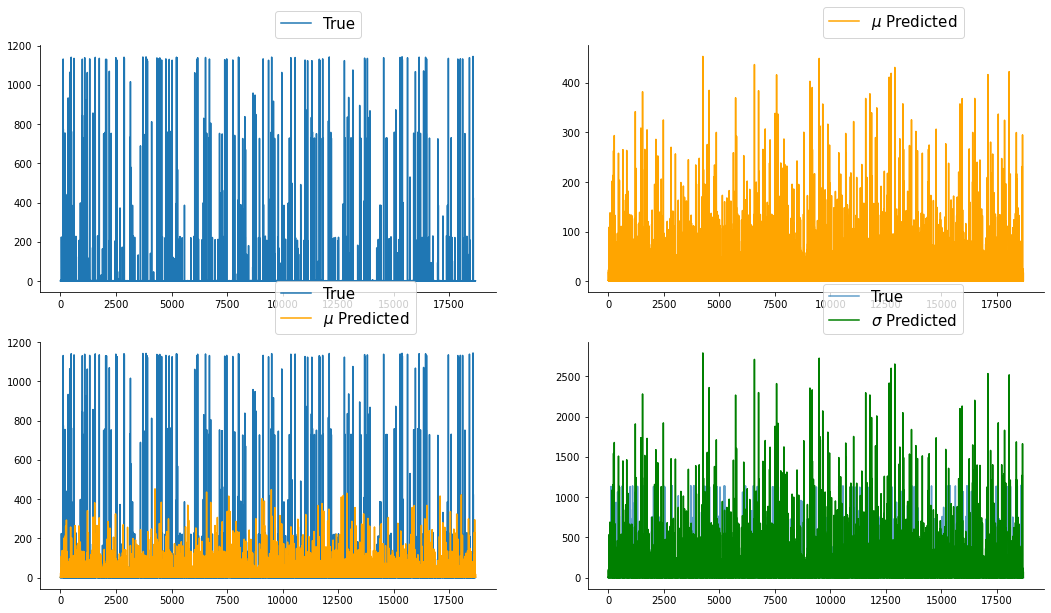

In [54]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [55]:
training_predictions_df['DE_mean']=de_train_mean
training_predictions_df['DE_sigma']=de_train_sigma

#### Calibration Set Results

In [56]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
de_cal_mean,de_cal_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

2022-07-23 13:58:30.360123: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[6230,19,500]{1,2,0}, u8[0]{0}) custom-call(f32[6230,19,400]{1,2,0}, f32[5,40,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-23 13:58:30.484506: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[6230,19,500]{1,2,0}, u8[0]{0}) custom-call(f32[6230,19,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"act

In [57]:
de_cal_mean = scaler_y.inverse_transform(de_cal_mean)
de_cal_sigma = (scaler_y.scale_*de_cal_sigma)



In [58]:
print(f"RMSE : {errors.rmse(y_true_cal, de_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, de_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(de_cal_mean, de_cal_sigma, y_true_cal):.4f}")

RMSE : 87.7253 MAE  : 19.3181 NLL  : 3.4407


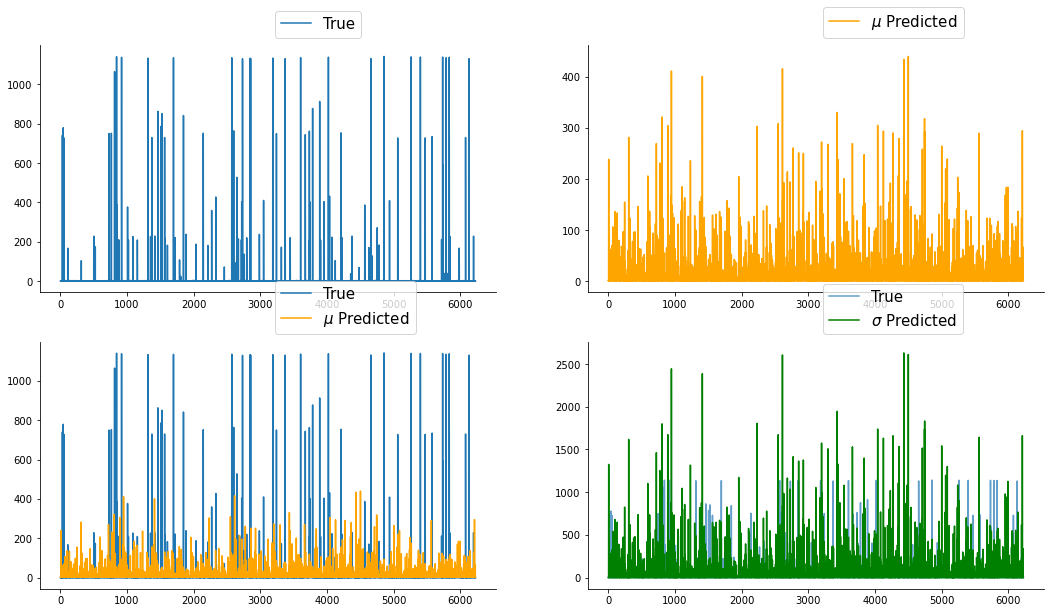

In [59]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(de_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [60]:
calibration_predictions_df['DE_mean']=de_cal_mean
calibration_predictions_df['DE_sigma']=de_cal_sigma

In [61]:
calibration_predictions_df.head()

,Ground Truth,mean,sigma,MC_Mean,MC_Sigma,DE_mean,DE_sigma
0,8.209751e-08,2.193967,0.695400,0.893627,0.602065,1.802344,0.639273
1,8.209751e-08,2.165525,0.610768,1.240131,0.735860,1.743076,0.557616
2,1.000000e+00,2.398623,0.685733,1.254830,0.729171,2.073365,0.662648
3,8.209751e-08,1.222906,1.817317,0.044785,2.152446,1.277007,1.757597
4,9.375001e-01,2.033292,0.593933,0.966160,0.545352,1.816042,0.585192


#### Testing Results

In [62]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_test, params_list)

In [63]:
de_testing_time = cap.stdout.split('\n')[1]
de_testing_time

'Wall time: 845 ms'

In [64]:
de_test_mean,de_test_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [65]:
de_test_mean = scaler_y.inverse_transform(de_test_mean)
de_test_sigma = (scaler_y.scale_*de_test_sigma)

In [66]:
testing_predictions_df['de_Mean'] =  de_test_mean
testing_predictions_df['de_Sigma'] = de_test_sigma

In [67]:
print(f"RMSE : {errors.rmse(y_test, de_test_mean):.4f}", f"MAE  : {errors.mae(y_test, de_test_mean):.4f}", 
      f"NLL  : {errors.NLL(de_test_mean, de_test_sigma, y_test):.4f}")

RMSE : 91.6680 MAE  : 12.4462 NLL  : 7.2745


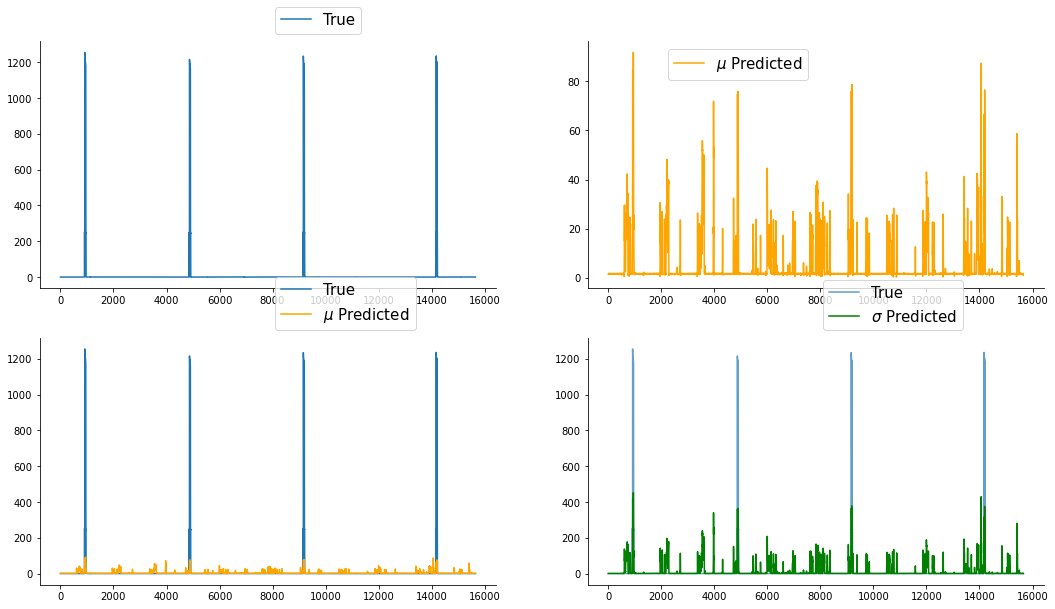

In [68]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

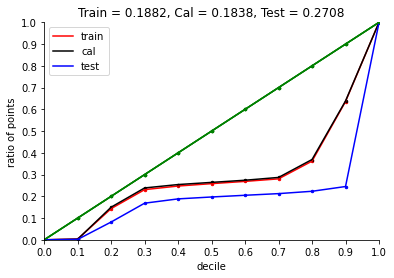

In [69]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(de_train_mean.squeeze(), de_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(de_cal_mean.squeeze(), de_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(de_test_mean.squeeze(), de_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Bootstrap

In [70]:
def bs_train(x, y, i, model):
    idx = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(len(x)), (len(x),))
    new_x, new_y = x[idx], y[idx]
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, new_x, new_y, True, batch_size=1024, 
                      learning_rate=0.0001, epochs= 50)
    return param, losses

bs_train = jax.tree_util.Partial(bs_train, model=model)

In [71]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(bs_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [72]:
bs_training_time = cap.stdout.split('\n')[1]
bs_training_time

'Wall time: 10.8 s'

#### Training Results

In [73]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
bs_train_mean,bs_train_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [74]:
bs_train_mean = scaler_y.inverse_transform(bs_train_mean)
bs_train_sigma = scaler_y.scale_*bs_train_sigma

In [75]:
print(f"RMSE : {errors.rmse(y_true, bs_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, bs_train_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_train_mean, bs_train_sigma, y_true):.4f}")

RMSE : 91.9041 MAE  : 16.7159 NLL  : 3.4310


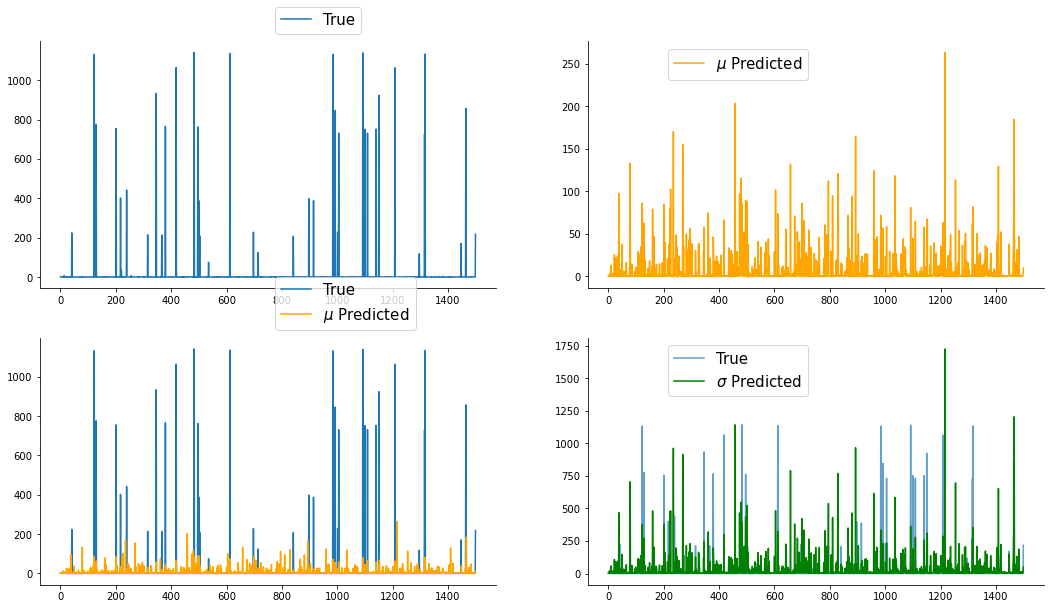

In [76]:
idx1 = 0
idx2 = 1500
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [77]:
training_predictions_df['BS_mean']=bs_train_mean
training_predictions_df['BS_sigma']=bs_train_sigma

#### Calibration Set Results

In [78]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_cal, params_list)
bs_cal_mean,bs_cal_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [79]:
bs_cal_mean = scaler_y.inverse_transform(bs_cal_mean)
bs_cal_sigma = scaler_y.scale_*bs_cal_sigma

In [80]:
print(f"RMSE : {errors.rmse(y_true_cal, bs_cal_mean):.4f}", 
      f"MAE  : {errors.mae(y_true_cal, bs_cal_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_cal_mean, bs_cal_sigma, y_true_cal):.4f}")

RMSE : 84.5026 MAE  : 15.1732 NLL  : 3.4223


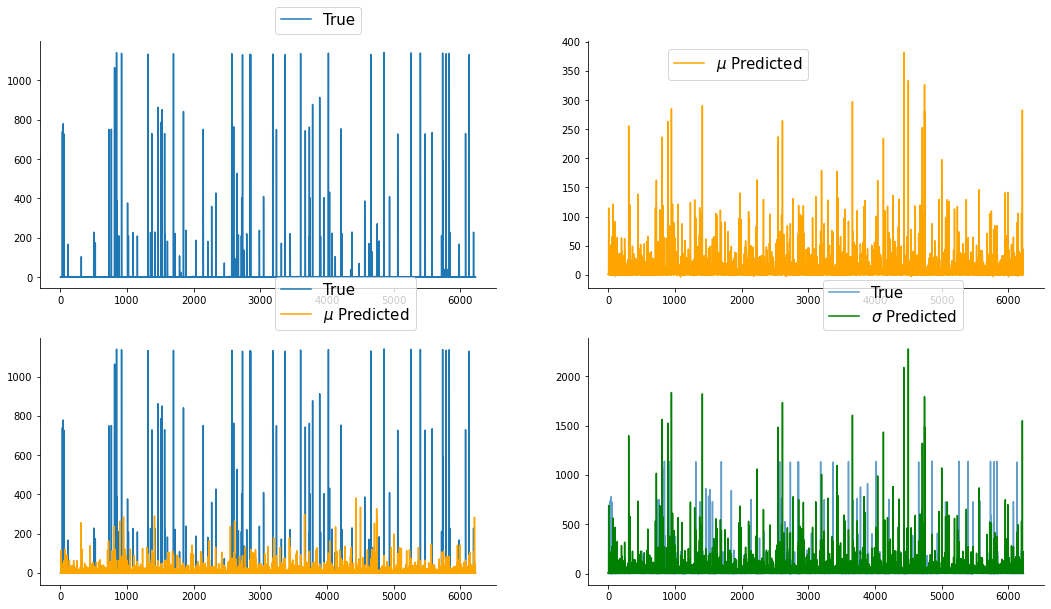

In [81]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true_cal[idx1:idx2], label="True")
ax[1].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true_cal[idx1:idx2], label="True")
ax[2].plot(bs_cal_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true_cal[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_cal_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [82]:
calibration_predictions_df['bs_Mean'] =  bs_cal_mean
calibration_predictions_df['bs_Sigma'] = bs_cal_sigma

#### Testing Results

In [83]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_test, params_list)

In [84]:
bs_testing_time = cap.stdout.split('\n')[1]
bs_testing_time

'Wall time: 270 ms'

In [85]:
bs_test_mean,bs_test_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [86]:
bs_test_mean = scaler_y.inverse_transform(bs_test_mean)
bs_test_sigma = scaler_y.scale_*bs_test_sigma

In [87]:
print(f"RMSE : {errors.rmse(y_test, bs_test_mean):.4f}", f"MAE  : {errors.mae(y_test, bs_test_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_test_mean, bs_test_sigma, y_test):.4f}")

RMSE : 91.5238 MAE  : 10.9979 NLL  : 3.2406


In [88]:
testing_predictions_df['bs_Mean'] =  bs_test_mean
testing_predictions_df['bs_Sigma'] = bs_test_sigma

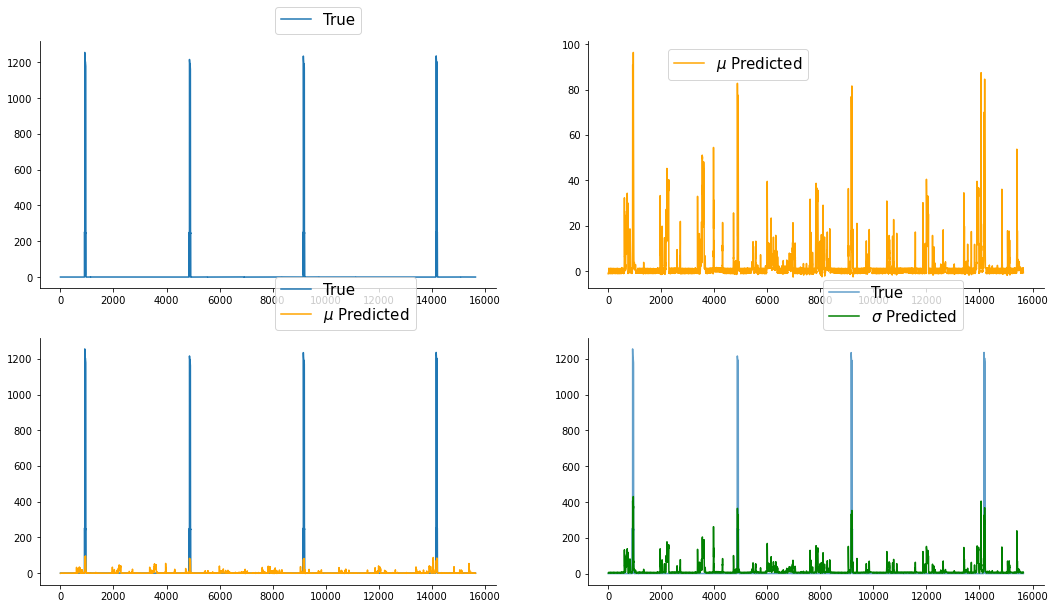

In [89]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

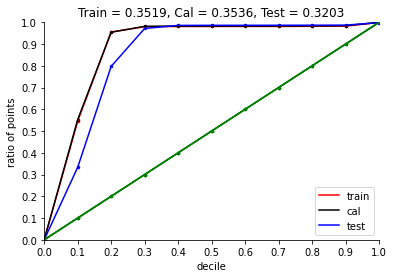

In [90]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(bs_train_mean.squeeze(), bs_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)
df, df2 = plot.calibration_regression(bs_cal_mean.squeeze(), bs_cal_sigma.squeeze(), 
                                      y_true_cal.squeeze(), "cal", "black", ax)
df, df3 = plot.calibration_regression(bs_test_mean.squeeze(), bs_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Cal = {errors.ace(df2):.4f}, Test = {errors.ace(df3):.4f}')
ax.legend()

## Save Results

In [91]:
testing_predictions_df.head()

,Timestamp,Ground Truth,mean,sigma,MC_Mean,MC_Sigma,de_Mean,de_Sigma,bs_Mean,bs_Sigma
0,2011-04-21 00:00:00-04:00,0.1250,1.864931,0.792918,0.377898,0.798268,1.450342,0.598410,-1.125756,2.809580
1,2011-04-21 00:01:00-04:00,0.1250,1.839977,0.774517,0.487284,0.815002,1.462979,0.600136,-1.144910,2.838008
2,2011-04-21 00:02:00-04:00,0.1250,1.839305,0.763822,0.123064,0.837985,1.462128,0.597067,-1.140837,2.846614
3,2011-04-21 00:03:00-04:00,0.0625,1.846201,0.763871,0.212478,0.753300,1.467105,0.599437,-1.122299,2.866882
4,2011-04-21 00:04:00-04:00,0.1250,1.873430,0.771789,0.217785,0.785810,1.481292,0.600825,-1.126983,2.893174


In [92]:
training_predictions_df.to_csv("notebooks/dishwasher/lstm/gmlp/training_predictions.csv",index=False)
calibration_predictions_df.to_csv("notebooks/dishwasher/lstm/gmlp/calibration_predictions.csv",index=False)
testing_predictions_df.to_csv("notebooks/dishwasher/lstm/gmlp/testing_predictions.csv",index=False)

In [93]:
with open('notebooks/dishwasher/lstm/gmlp/time.txt', 'w') as file:
    file.writelines([f"MLP training :{mlp_training_time} ",f" MLP Testing : {mlp_testing_time}\n"
               f"MC Testing : {mc_testing_time}\n", 
               f"DE Training Time : {de_training_time} ",f" DE Testing Time: {de_testing_time}\n", 
               f"BS Training Time : {bs_training_time} ",f" BS Testing Time: {bs_testing_time}"])